# Synthetic drifter trajectories exponentially autocorrelated velocities n=1
- use synthetic exponentially autocorrelated velocity timeseries generated by zarr_synthetic_trajectories with n=1.
- verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
- Fit to theoritical PSD and autocorrelation functions
- verify the Parseval's theorem
References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


---

# n=1 Exponentially autocorrelated low-frequency velocity signal 
- theoritical spectra
- fit to theoritical spectra
- Parseval verification

In [1]:
import os
import xarray as xr
import numpy as np
import viggiano_2020 as vig

import matplotlib.pyplot as plt
from cycler import cycler

import viggiano_2020 as vig
import plot as fplt
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

from GDP_lib import root_dir

In [2]:
u_low = sg.low_frequency_signal()

# note we also could consider / add a high frequency component
# u_high = sg.high_frequency_signal()

- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [3]:
T, U = u_low.p["T"], u_low.p["U"]
# sigma = u_high.p['sigma']
omega, tau = u_low.omega, u_low.tau

# print analytical spectrum
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

Such spectrum leads to a flat acceleration spectrum at high frequencies which cannot be integrated and suggests acceleration is white noise. 
$\omega= 2\pi f$

## Generate

In [3]:
# decorrelation timescales
T = [5, 10, 20, 40]
t = (1000, 1 / 24)  # timeline: 1000 days with hourly sampling
N = 40  # number of random draws
u_std = 2

In [4]:
# generate velocity first
da = (
    u_low.generate_tseries(
        params=dict(T=T),
        draws=N,
        time=t,
        seed=0,
    )
    * u_std
)
# derive position and acceleration
ds = da.rename("u").assign_attrs(units="m/s").to_dataset().persist()
ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = (
    ds["u"].cumulative_integrate("time").assign_attrs(units="m") * 86400
)  # rescale in m
ds["a"] = (
    ds["u"].differentiate("time").assign_attrs(units="m/s^2") / 86400
)  # rescale in m/s
ds = ds.persist()
print(1)
# compute autocorrelations
xx = (
    sigp.correlate(ds.x, ds.x)
    .rename("xx")
    .persist()
    .assign_attrs(long_name=r"$C_x(\tau)$", units="")
)
uu = (
    sigp.correlate(ds.u, ds.u)
    .rename("uu")
    .persist()
    .assign_attrs(long_name=r"$C_u(\tau)$", units="")
)
aa = (
    sigp.correlate(ds.a, ds.a)
    .rename("aa")
    .persist()
    .assign_attrs(long_name=r"$C_a(\tau)$", units="")
)
dsc = xr.merge([xx, uu, aa])
print(2)
# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
Eu, omega = sigp.spectrum_welch(ds.u, T=100)
Ea, omega = sigp.spectrum_welch(ds.a, T=100)
dsE = xr.merge(
    [
        Ex.assign_attrs(units=r"$m^2/cpd$"),
        Eu.assign_attrs(units=r"$m^2/s^2/cpd$"),
        Ea.assign_attrs(units=r"$m^2/s^4/cpd$"),
    ]
)
dsE = dsE.rename({i: "E" + i for i in list(dsE.keys())})
print(3)
ds_exp = xr.merge([ds, dsc, dsE])

ds_exp.T.attrs = {"long_name": "Correlation time T", "units": "days"}
ds_exp.lags.attrs = {"long_name": r"$\tau$", "units": "days"}
ds_exp.freq_time.attrs = {"units": "cpd"}

ds_exp.attrs = {
    "description": "synthetic trajectories simulated via the embedded OU process of Viggiano et al. 2020 (equations (2.14-2.18))",
    "n_layers": 1,
    "sigma_u": u_std,
}

1
2
3


In [8]:
ds = ds_exp

### Store

In [5]:
ds_exp0 = ds_exp.chunk({"T": 4, "time": 5000, "draw": -1, "lags": 5000})
# ds_exp0['draw'] = xr.DataArray(np.arange(80,100), dims=['draw'])

In [6]:
# root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
ds_exp0 = ds_exp.chunk({"T": 4, "time": 5000, "draw": -1, "lags": 5000})
path = os.path.join(root_dir, "synthetic_traj_exp.zarr")

ds_exp0.to_zarr(path, mode="w")
# ds_exp0.to_zarr(path, mode="a", append_dim='draw')

## Or load

In [2]:
path = os.path.join(root_dir, "synthetic_traj_exp.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)

________________
## Analysis

In [3]:
### Theoritical PSD or correlation for exponentially correlated process
def PSDu_exp(sigma, T, omega):
    return 2 * T * sigma**2 / (1 + T**2 * omega**2)


def PSDa_exp(sigma, T, omega):
    return 2 * T * sigma**2 / (1 + T**2 * omega**2) * (omega / 86400) ** 2


def correlation_exp(tau, T, sigma):
    return sigma**2 * np.exp(-tau / T)

In [3]:
ds["PSDu"] = vig.PSDu_1_ds(ds)
ds["PSDa"] = vig.PSDa_1_ds(ds)
ds["coru"] = vig.Coru_1_ds(ds)
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 40, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 40, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 40), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 40, 5000), meta=np.ndarray>
    PSDu       (T, freq_time) float64 0.0002814 0.0002819 ... 3.53e-05 3.524e-05
    PSDa       (T, freq_time) float64 2.143e-10 2.143e-10 ... 2.679e-11
    coru       (lags, T) float64 4.0 4.0 4.0 ... 1.494e-43 7.731e-22 5.561e-11
Attributes:
    description:  synthetic trajectories simulated via the embedded OU proces...
    n_layers:     1
    sigma_u:      2

In [4]:
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc("axes", prop_cycle=cycler(color=colors))

___
## Theoritical spectra

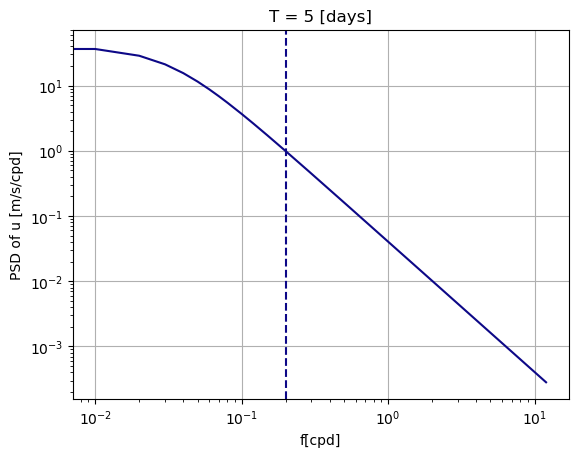

In [5]:
ds.PSDu.sel(T=5).plot(color=colors[0])
plt.axvline(1 / 5, ls="--", color=colors[0])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("f[cpd]")
plt.ylabel("PSD of u [m/s/cpd]")
plt.grid()

___
## Fit

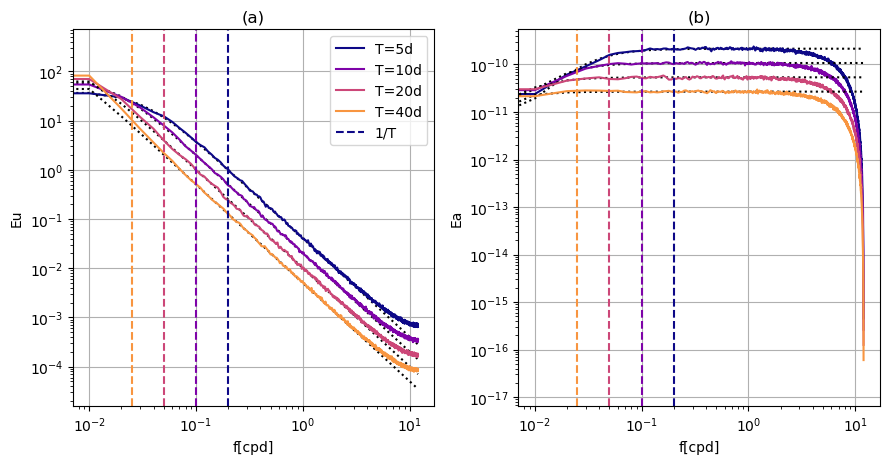

In [6]:
fplt.plot_psd(ds);

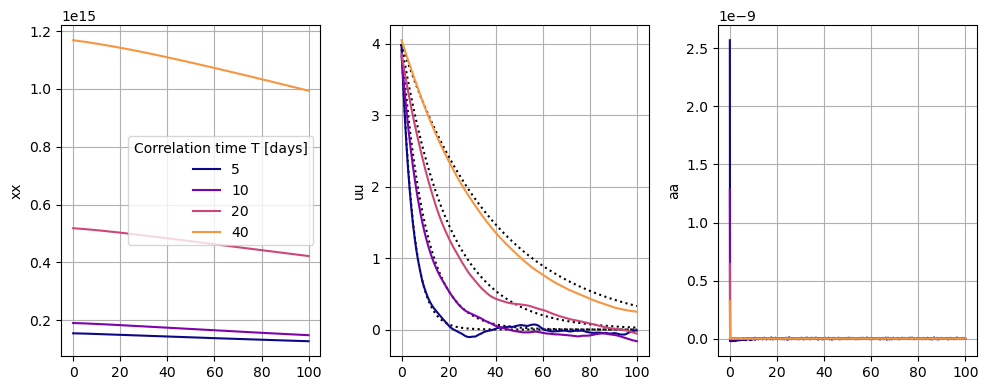

In [7]:
fplt.plot_autocorrelations(ds.mean("draw"), tau_max=100);

## Verify Parseval

In [8]:
ds.Eu.integrate("freq_time").compute()

<xarray.DataArray 'Eu' (T: 4, draw: 40)>
array([[3.41440826, 3.71997886, 4.04824052, 3.6377907 , 4.50155142,
        3.70877806, 3.83882508, 3.07509376, 3.76648486, 4.08700309,
        4.56390206, 3.7304468 , 4.2939237 , 4.20503022, 4.46458294,
        3.69386107, 4.07835838, 3.91235924, 4.0848159 , 4.12537127,
        3.69510887, 4.49576226, 3.36755426, 4.6303909 , 4.01003204,
        4.33431633, 4.76730072, 4.62572653, 4.05241881, 4.18395754,
        4.04048168, 3.97149382, 4.00001871, 4.13675579, 3.93245255,
        3.93377127, 4.07102114, 3.90099872, 3.51560283, 3.88703835],
       [4.0691211 , 4.60679768, 3.19168014, 4.24507494, 3.15585344,
        3.74864761, 4.48207283, 4.26060908, 3.62171752, 3.68022578,
        3.53682046, 4.81917965, 3.40150183, 3.56634713, 3.87116104,
        3.70423273, 3.43521231, 3.72182523, 3.66636793, 3.50565689,
        3.7859943 , 3.32831021, 3.71783637, 4.74349354, 4.02060488,
        4.05848753, 5.20880783, 4.31197007, 3.4207126 , 3.31943233,
        3.60532905, 3.4578877 , 4.56708444, 3.90381233, 4.01872067,
        4.02769652, 3.24861633, 3.28546248, 3.23943331, 4.27083393],
       [3.09294108, 3.75856141, 4.66983054, 4.02258292, 4.40014238,
        5.4163813 , 4.03017083, 3.9941075 , 2.46212981, 3.38431364,
        3.25832707, 5.66439299, 4.10178329, 6.01375501, 3.43931949,
        3.64259733, 3.32285129, 3.23887621, 3.61380783, 2.45307371,
        3.55426151, 3.42559741, 3.28418073, 4.17025587, 3.45440366,
        3.58913776, 3.844208  , 4.04538774, 4.61609444, 2.7788192 ,
        3.78828059, 4.08641409, 3.24969713, 4.31100893, 2.96564137,
        4.6683771 , 4.72481844, 3.65782356, 3.87218655, 4.87644746],
       [5.66519978, 3.00416385, 4.10067736, 4.80665822, 4.54169828,
        4.16318428, 4.32043904, 3.38372047, 2.59210245, 3.33790803,
        4.29514825, 5.92636039, 2.44194018, 5.05083975, 3.81574002,
        3.92747844, 3.74972995, 2.93187824, 2.77820296, 5.99871479,
        4.20377588, 4.3323589 , 3.81978086, 2.69857743, 4.88434538,
        6.39766869, 6.82242004, 4.46308126, 3.71095095, 5.30581553,
        3.45697083, 3.6135341 , 6.99127041, 3.13451049, 3.53190058,
        3.41954002, 3.42099372, 4.37214203, 2.95682386, 3.77415743]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39

In [9]:
ds.PSDu.integrate("freq_time").compute()

<xarray.DataArray 'PSDu' (T: 4)>
array([3.99324247, 3.99698444, 4.05257985, 4.71455922])
Coordinates:
  * T        (T) int64 5 10 20 40